In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Validation
- Theoretically, we saw that for any hypothesis in a given class and any data distribution, the true risk is close to the empirical risk.
- However, this bound can be loose, and a more accurate estimate of the true risk can be obtained by evaluating the model on a validation set.

## Validation Set(Hold-out Set)

A validation set $V$ is an additional set of example independent of training set which is used to estimate the true risk $L_D(h)$ of a model.

### **(A) Training Bound**  
$
L_D(h) \leq L_S(h) + \sqrt{C \frac{d + \log(1/\delta)}{m}}
$
- For a hypothesis h obtained by applying ERM predictor with respect to a hypothesis class of VC dim d.
- There is a complexity penalty on the bound.

### **(B) Validation Bound**  
$
L_D(h) \leq L_V(h) + \sqrt{\frac{\log(2/\delta)}{2m_v}}  
$
- **No complexity penalty**, making it **tighter**.<br>

We have established that the true error has a tighter bound with validation set.<br>
Now we want to minimize the validation error.<br>

## Model Selection Curve

It shows training error and validation error as a function of the complexity of the model.

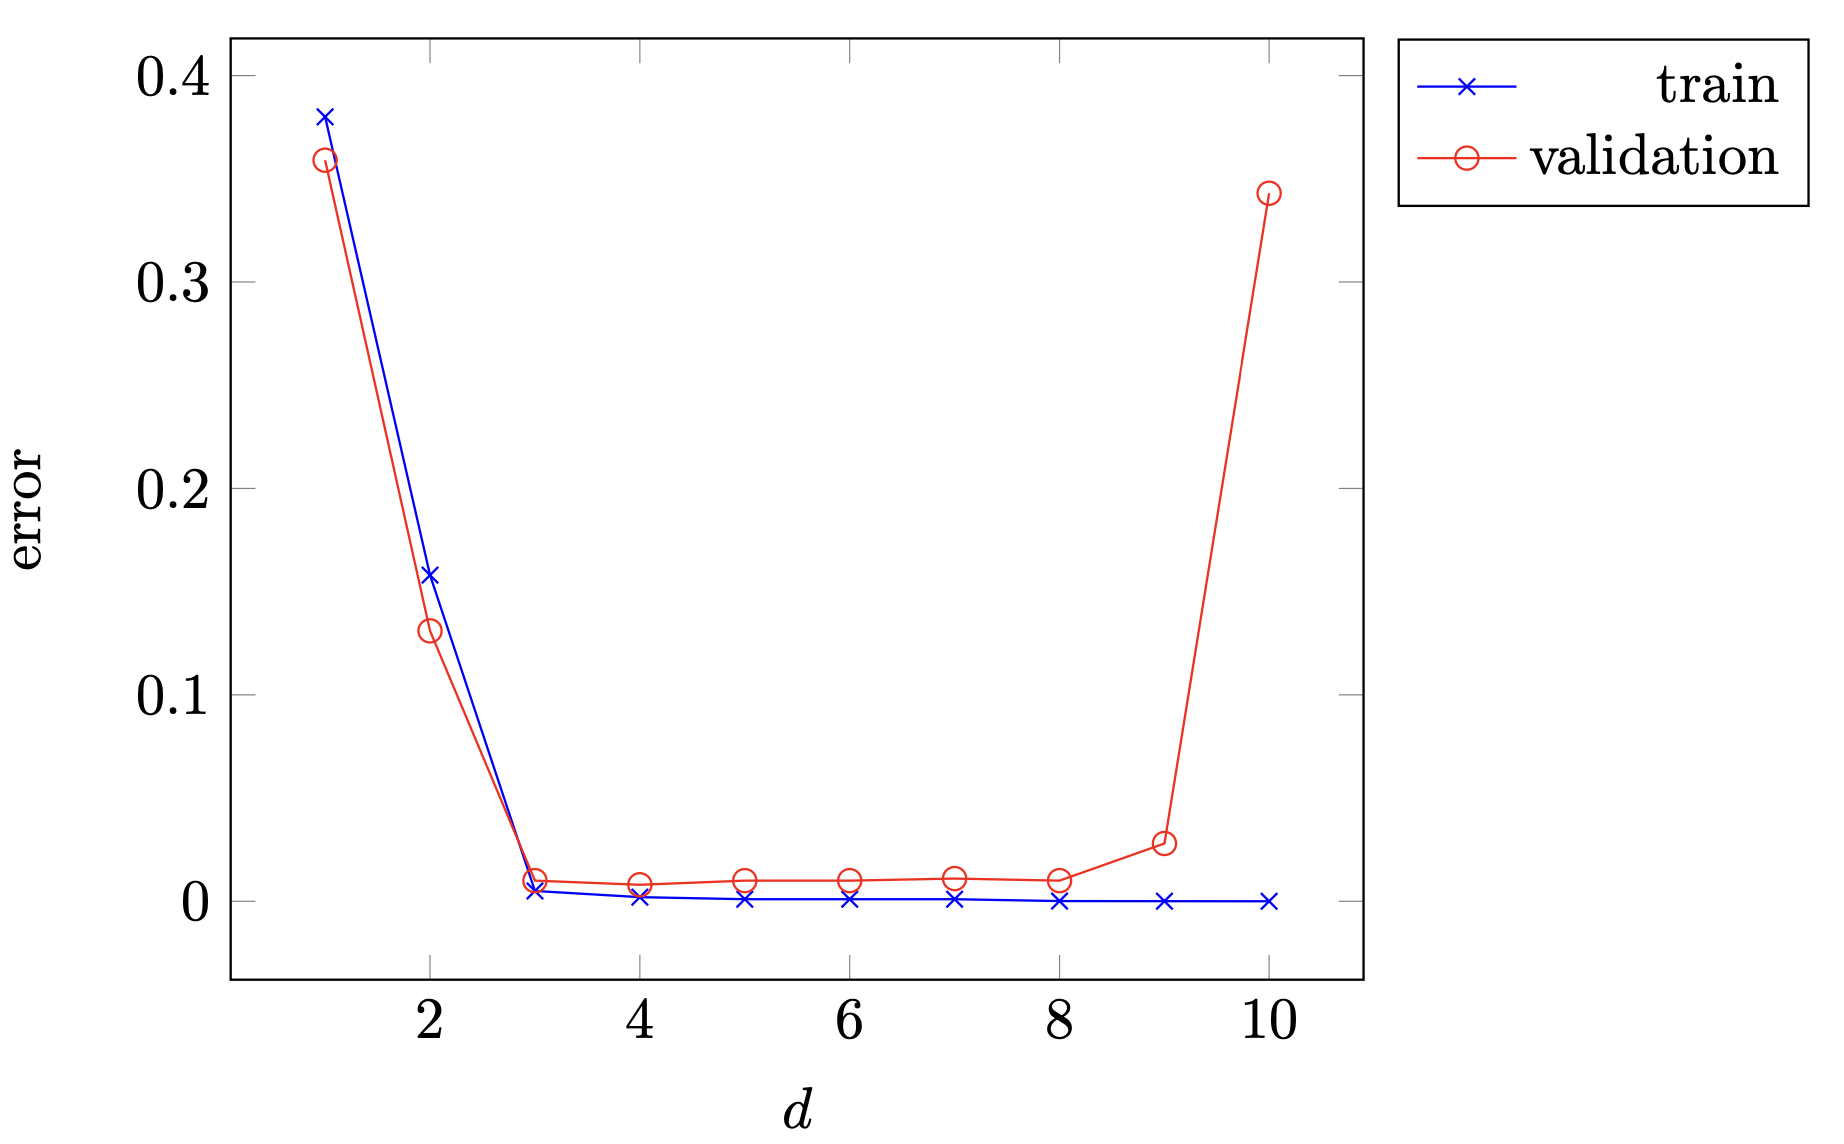

In [ ]:
from IPython.display import display, Image
display(Image("/content/drive/MyDrive/BTP/plot.png", width=500, height=500))


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import time
from sklearn.model_selection import KFold, cross_val_predict



plt.rcParams["figure.figsize"] = (10, 10)

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["Target"] = data.target # Adding a new target column(prices) to the dataframe
print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


## Dataset

The California Housing Dataset contains housing data collected from the 1990 U.S. Census.<br>
The dataset includes 8 features (columns) that describe the average characteristics of houses in a block group:
- MedInc : median income of households in the region in tens of thousands of dollars
- HouseAge : Average age of houses in the area (in years).
- AveRooms : Average number of rooms per household.
- AveBedrms : Average number of bedrooms per household.
- Population : Total number of people living in the block group.
- AveOccup : Average number of people per household.
- Latitude : North-South location of the block group.
- Longitude : East-West location of the block group.
- Target :  It contains the median house price (in $100,000s) for a block group.


In [ ]:
# Summary of the dataset
print(df.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        Target  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

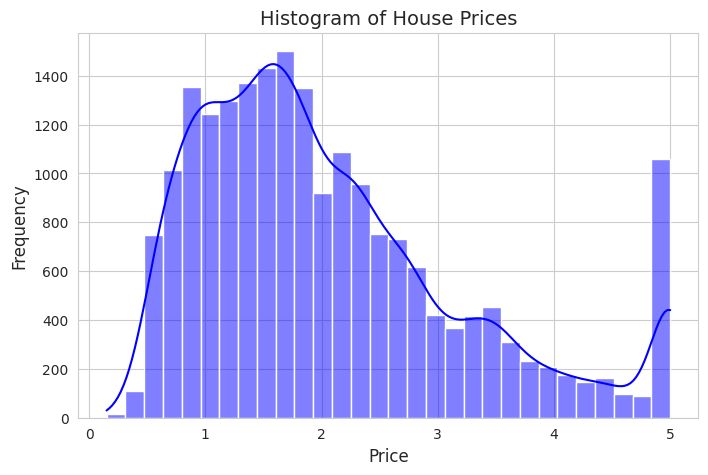

In [ ]:
# Plotting the Number of houses at a given price in 100,000$
plt.figure(figsize=(8, 5))
sns.histplot(df["Target"], bins=30, kde=True, color="blue")
plt.title("Histogram of House Prices", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

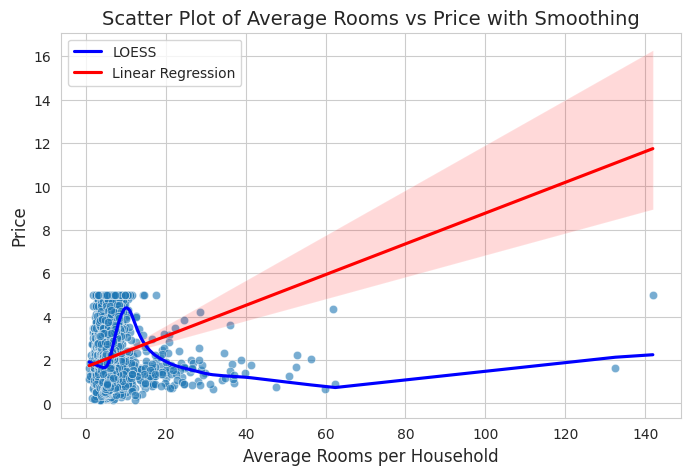

In [ ]:
# Creating a scatter plot with LOESS and Linear Regression smoothing
plt.figure(figsize=(8, 5))
# The following seaborn functions are used to plot scatter plots along with regression line if we set lowess=true it uses locally estimated scattered plot smoothing to create smooth non linear curve
sns.scatterplot(x=df["AveRooms"], y=df["Target"], alpha=0.6)

sns.regplot(x=df["AveRooms"], y=df["Target"], lowess=True, scatter=False, color="blue", label="LOESS")

sns.regplot(x=df["AveRooms"], y=df["Target"], scatter=False, color="red", label="Linear Regression")

plt.xlabel("Average Rooms per Household", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.title("Scatter Plot of Average Rooms vs Price with Smoothing", fontsize=14)
plt.legend()

plt.show()

## Plot
LOESS (Locally Estimated Scatterplot Smoothing) is a non-parametric (no fixed mathematical form assumption) regression technique that integrates many small localised regressions at different places in the data.

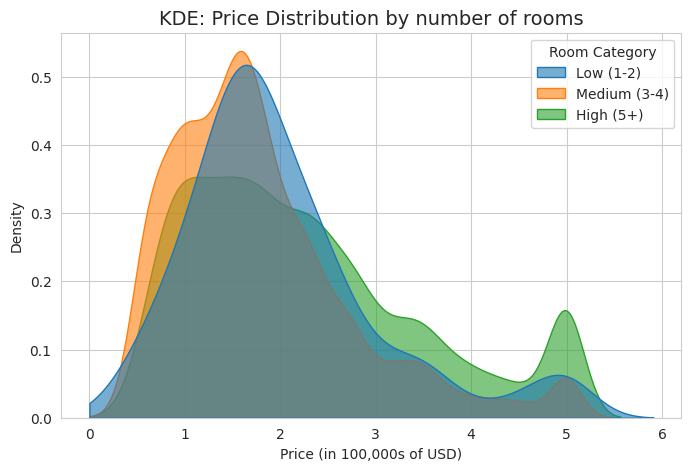

In [ ]:
# Convert "AveRooms" into integer bathrooms (approximation)
df["Rooms"] = df["AveRooms"].astype(int)

df["Room Category"] = pd.cut(df["Rooms"], bins=[0, 2, 4, np.inf],
                                 labels=["Low (1-2)", "Medium (3-4)", "High (5+)"])

df = df[df["Target"] > 0]

# Set style
sns.set_style("whitegrid")

fig, axes = plt.subplots(figsize=(8, 5))

sns.kdeplot(data=df, x="Target", hue="Room Category", fill=True, common_norm=False,
            alpha=0.6, clip=(0, None))
plt.title("KDE: Price Distribution by number of rooms", fontsize=14)
plt.xlabel("Price (in 100,000s of USD)")
plt.ylabel("Density")

plt.show()

- Kernel Density Estimation (KDE) is a way to estimate the probability distribution of a dataset. It helps us visualize how data points are distributed smoothly.
- The plot above shows for larger houses the distribution is more spread out

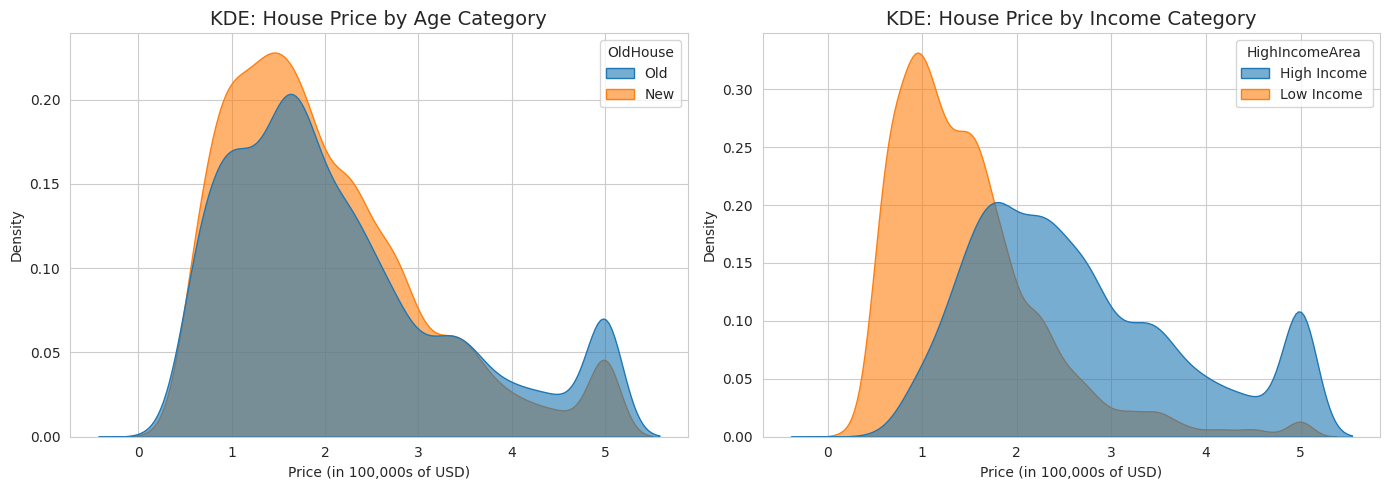

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["Price"] = data.target

df["OldHouse"] = np.where(df["HouseAge"] > df["HouseAge"].median(), "Old", "New")
df["HighIncomeArea"] = np.where(df["MedInc"] > df["MedInc"].median(), "High Income", "Low Income")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(data=df, x="Price", hue="OldHouse", fill=True, alpha=0.6, ax=axes[0])
axes[0].set_title("KDE: House Price by Age Category", fontsize=14)
axes[0].set_xlabel("Price (in 100,000s of USD)")
axes[0].set_ylabel("Density")

sns.kdeplot(data=df, x="Price", hue="HighIncomeArea", fill=True, alpha=0.6, ax=axes[1])
axes[1].set_title("KDE: House Price by Income Category", fontsize=14)
axes[1].set_xlabel("Price (in 100,000s of USD)")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()



### Heteroskedasticity :    
- A statistical condition where the variance of errors is not constant across observations
- For instance Price of low income blocks or smaller houses are in narrow range while houses having more rooms or in high income blocks have wider range.
- This means that as the number of rooms increases, the spread (variance) of errors also increases which is heteroskedasticity.

## Cross Validation
- Cross-validation is a technique for evaluating a machine learning model and testing its performance. It helps to compare and select an appropriate model for the specific predictive modeling problem.
- There are a lot of different techniques that may be used to cross-validate a model. Still, all of them have a similar algorithm:

  1. Divide the dataset into two parts: one for training, other for testing
  2. Train the model on the training set
  3. Validate the model on the test set
  4. Repeat 1-3 steps a couple of times. This number depends on the CV method that you are using


## Hold - Out Cross Validation

                   R² Score      RMSE       MAE
Linear Regression  0.623378  0.207519  0.159393
Time taken: 0.0354 seconds




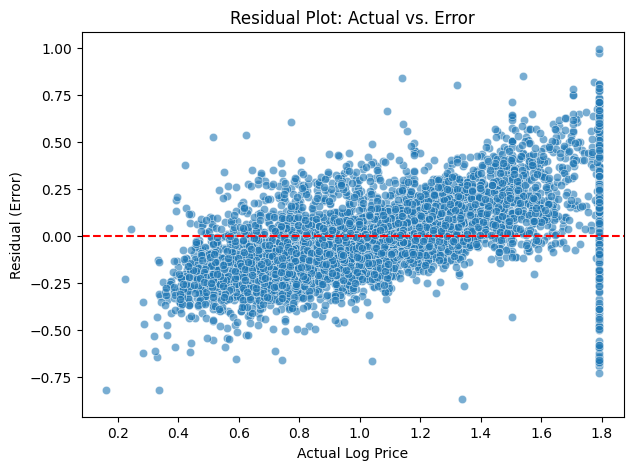

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["Price"] = data.target

# Log-transform Price and Lot Size to handle heteroskedasticity
df["Price"] = np.log(df["Price"]+1)
df["AveRooms"] = np.log(df["AveRooms"]+1)

# Handle any missing values if they exist
df = df.dropna()

# Split the data into training (75%) and test (25%) sets
X = df.drop(columns=["Price"])
y = df["Price"]
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
end_time = time.time()

results = {
    "R² Score": r2_score(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test),
    "MAE": mean_absolute_error(y_test, y_pred) / np.mean(y_test)
}


print(pd.DataFrame(results, index=["Linear Regression"]))
print(f"Time taken: {end_time - start_time:.4f} seconds\n\n")

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_test - y_pred, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")  # Reference line at zero error
plt.xlabel("Actual Log Price")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot: Actual vs. Error")
plt.show()

## K Fold Cross Validation

- The k-fold cross validation technique is designed to give an accurate estimate of the true error without wasting too much data.
- In k-fold cross validation the original training set is partitioned into k subsets (folds) of size m/k.
- For each fold the algorithm is trained on the union of the other folds and then the error of its output is estimated using the fold.
- the average of all these errors is the estimate of the true error.

## **Algorithm:**

**Input:**
- Training set \( S = \{(x_1,y_1), (x_2,y_2), $\dots$, (x_m,y_m)\} \)
- Set of parameter values $\Phi$
- Learning algorithm \( A \)
- Integer \( k \)

**Algorithm:**

1. Partition the dataset \( S \) into \( k \) subsets: \( S_1, S_2, $\dots$, S_k \).

2. For each parameter $\theta$ $\in$ $\phi$:
    - For each fold \( i = 1, 2, $\dots$, k \):
        - Train the model:
        $$
        h_{i,\theta} = A(S \setminus S_i; \theta)
        $$
    - Compute the average error:
    $$
    \text{error}(\theta) = \frac{1}{k}\sum_{i=1}^{k} L_{S_i}(h_{i,\theta})
    $$

3. Select the best parameter $\theta^\star$ that minimizes validation error:
$$
\theta^\star = \arg\min_{\theta} [\text{error}(\theta)]
$$

4. Train the final model using the entire dataset \( S \) and the best parameter $\theta^\star$:
$$
h_{\theta^\star} = A(S; \theta^\star)
$$

**Output:**
- Best parameter: \( $\theta^\star$)
- Final trained model: \( h_{$\theta^\star$} \)


Fold 1: R²: 0.6370, RMSE: 0.2032, MAE: 0.1551
Fold 2: R²: 0.6170, RMSE: 0.2072, MAE: 0.1595
Fold 3: R²: 0.6172, RMSE: 0.2135, MAE: 0.1655
Fold 4: R²: 0.6081, RMSE: 0.2134, MAE: 0.1593
Fold 5: R²: 0.6246, RMSE: 0.2051, MAE: 0.1595
Fold 6: R²: 0.6227, RMSE: 0.2096, MAE: 0.1602
Fold 7: R²: 0.6292, RMSE: 0.2047, MAE: 0.1554
Fold 8: R²: 0.6122, RMSE: 0.2093, MAE: 0.1597
Fold 9: R²: 0.6130, RMSE: 0.2048, MAE: 0.1567
Fold 10: R²: 0.6155, RMSE: 0.2077, MAE: 0.1576

Mean R² Score: 0.6196
Mean RMSE: 0.2079
Mean MAE: 0.1588
Time taken: 0.7315 seconds


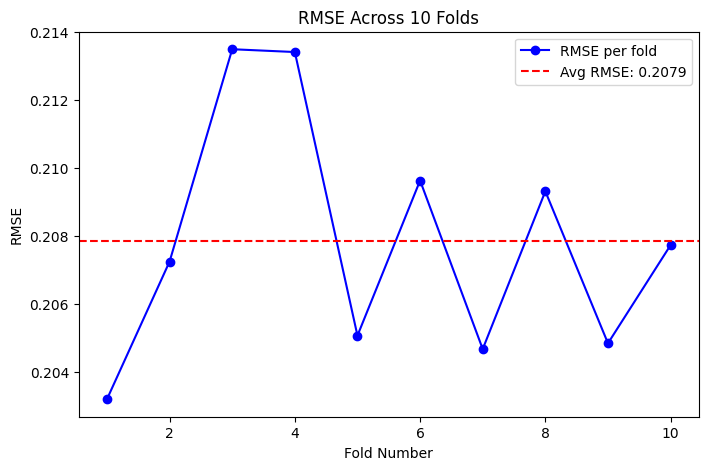

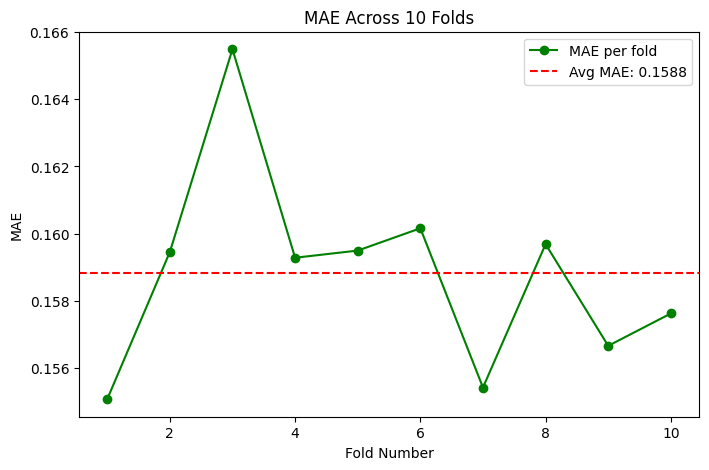

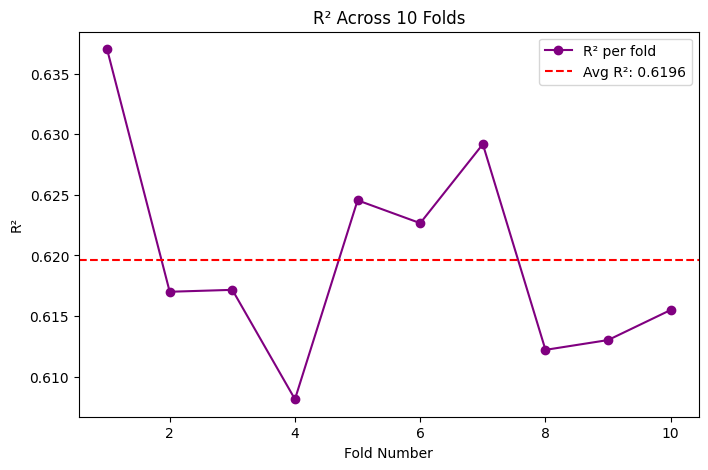

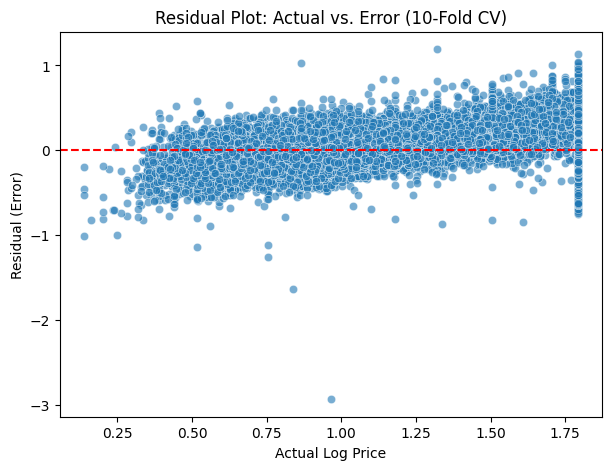

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["Price"] = data.target

df["Price"] = np.log(df["Price"] + 1)
df["AveRooms"] = np.log(df["AveRooms"] + 1)

df = df.dropna()

X = df.drop(columns=["Price"])
y = df["Price"]

kf = KFold(n_splits=10, shuffle=True, random_state=123)
model = LinearRegression()

rmse_scores = []
mae_scores = []
r2_scores = []
y_actual = []
y_pred_all = []

start_time = time.time()
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test)
    mae = mean_absolute_error(y_test, y_pred) / np.mean(y_test)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    y_actual.extend(y_test)
    y_pred_all.extend(y_pred)

    print(f"Fold {fold}: R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

end_time = time.time()

mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)

print(f"\nMean R² Score: {mean_r2:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Time taken: {end_time - start_time:.4f} seconds")

def plot_metric(scores, avg_value, metric_name, color):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), scores, marker='o', linestyle='-', label=f"{metric_name} per fold", color=color)
    plt.axhline(avg_value, color="red", linestyle="--", label=f"Avg {metric_name}: {avg_value:.4f}")
    plt.xlabel("Fold Number")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} Across 10 Folds")
    plt.legend()
    plt.show()

plot_metric(rmse_scores, mean_rmse, "RMSE", "blue")
plot_metric(mae_scores, mean_mae, "MAE", "green")
plot_metric(r2_scores, mean_r2, "R²", "purple")

plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_actual, y=np.array(y_actual) - np.array(y_pred_all), alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual Log Price")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot: Actual vs. Error (10-Fold CV)")
plt.show()

## Multiple K fold cross validation

- Multiple values of K are used to evaluate models performance on various metrics like RMSE, R², MAE enabling us to see the robustness and its accuracy over different K values aiding in determining the best value for K as plotted below.

- It also provides a more generalized measure of how well the model will perform on unseen data. By testing various values of K, the most suitable K that balances model performance and computational efficiency can also be determined.

<ipython-input-7-b741621ae73d>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_accuracy = pd.concat([df_accuracy, pd.DataFrame([compute_cv_metrics(K)])], ignore_index=True)


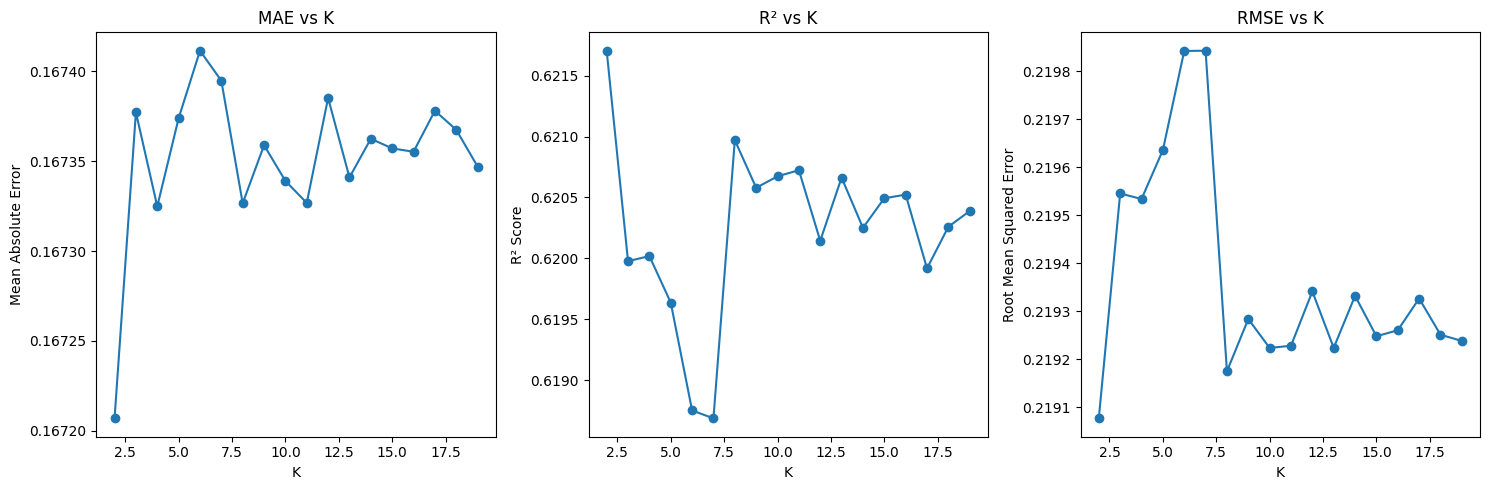

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["Price"] = data.target

df["Price"] = np.log(df["Price"] + 1)

df = df.dropna()

X = df.drop(columns=["Price"])
y = df["Price"]

df_accuracy = pd.DataFrame(columns=["K", "MAE", "RMSE", "R2"])

def compute_cv_metrics(K):
    kf = KFold(n_splits=K, shuffle=True, random_state=123)
    model = LinearRegression()

    mae_list, rmse_list, r2_list = [], [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))

    return {
        "K": K,
        "MAE": np.mean(mae_list),
        "RMSE": np.mean(rmse_list),
        "R2": np.mean(r2_list)
    }

for K in range(2, 20):
    df_accuracy = pd.concat([df_accuracy, pd.DataFrame([compute_cv_metrics(K)])], ignore_index=True)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(df_accuracy["K"], df_accuracy["MAE"], marker="o")
axes[0].set_title("MAE vs K")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Mean Absolute Error")

axes[1].plot(df_accuracy["K"], df_accuracy["R2"], marker="o")
axes[1].set_title("R² vs K")
axes[1].set_xlabel("K")
axes[1].set_ylabel("R² Score")

axes[2].plot(df_accuracy["K"], df_accuracy["RMSE"], marker="o")
axes[2].set_title("RMSE vs K")
axes[2].set_xlabel("K")
axes[2].set_ylabel("Root Mean Squared Error")

plt.tight_layout()
plt.show()

After K=8 , performance stabilizes because further increasing K doesn’t meaningfully improve the model’s ability to generalize or reduce performance variance, and computational costs start to outweigh the benefits.

## Leave-One-Out Cross-Validation

Leave-one-out сross-validation (LOOCV) is an extreme case of k-Fold CV where k is equal to the number of samples in the dataset.

Mean R² Score (LOOCV): 0.6120
RMSE: 0.6198
MAE: 0.4703
Time taken: 256.28 seconds


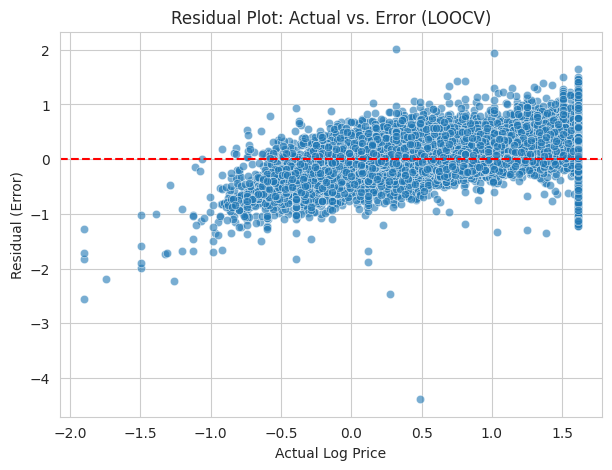

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["Price"] = data.target

df["Price"] = np.log(df["Price"])
df["AveRooms"] = np.log(df["AveRooms"])

df = df.dropna()

X = df.drop(columns=["Price"])
y = df["Price"]

loo = LeaveOneOut()
model = LinearRegression()

start_time = time.time()
y_pred = cross_val_predict(model, X, y, cv=loo)
end_time = time.time()

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred)) / np.mean(y)
mae = mean_absolute_error(y, y_pred) / np.mean(y)

print(f"Mean R² Score (LOOCV): {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

plt.figure(figsize=(7,5))
sns.scatterplot(x=y, y=y - y_pred, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual Log Price")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot: Actual vs. Error (LOOCV)")
plt.show()

## Repeated K-Fold Cross Validation
 - Repeated K-Fold ensures that the model is evaluated more thoroughly. It reduces the possibility that the model's performance is due to an unlucky split of the data. The more repetitions and splits you have, the more robust and reliable the performance estimates will be.

- It ensures better use of available data, especially for small datasets, by allowing each data point to be part of both the training and test sets across different iterations.

- It also helps mitigate overfitting and underfitting by exposing the model to diverse data splits and providing consistent, reliable metrics for model comparison and hyperparameter tuning.

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Longitude']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Mean Absolute Error (MAE): 0.1726
Root Mean Squared Error (RMSE): 0.2256
R² Score: 0.5988


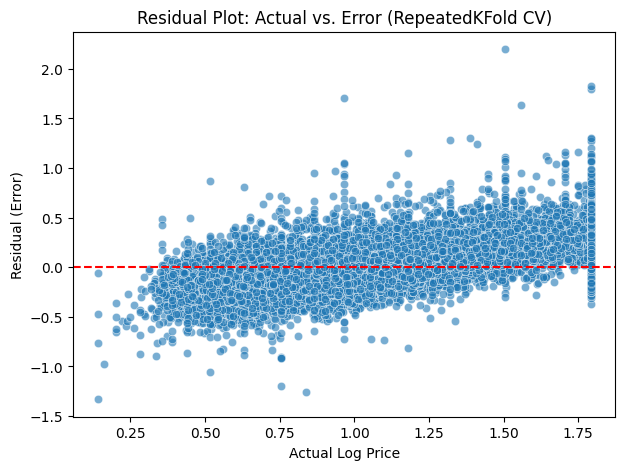

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)

df["Price"] = data.target

X = df.drop(columns=["Price"])
y = df["Price"]

X = X.replace(0, 1e-9)
X = np.log1p(X)
y = np.log1p(y)

imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

rkf = RepeatedKFold(n_splits=8, n_repeats=5, random_state=123)
model = LinearRegression()

y_pred = np.zeros_like(y)

for train_index, test_index in rkf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)

    y_pred[test_index] = model.predict(X_test)

residuals = y - y_pred

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(7, 5))
sns.scatterplot(x=y, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual Log Price")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot: Actual vs. Error (RepeatedKFold CV)")
plt.show()


## Learning curve for model selection
A learning curve provides valuable insights into how a model performs as it is trained on increasing amounts of data.

It helps in following ways:
- Monitoring and improving model performance. Allows to visualize how a model’s performance improves as more data is used for training.

- Detecting issues like overfitting or underfitting early in the training process. By plotting the training and validation (or test) error, a learning curve can highlight if your model is overfitting (learning the noise in the training data) or underfitting (not learning enough from the training data).

- Making informed decisions about model complexity, training data size, and hyperparameter tuning.

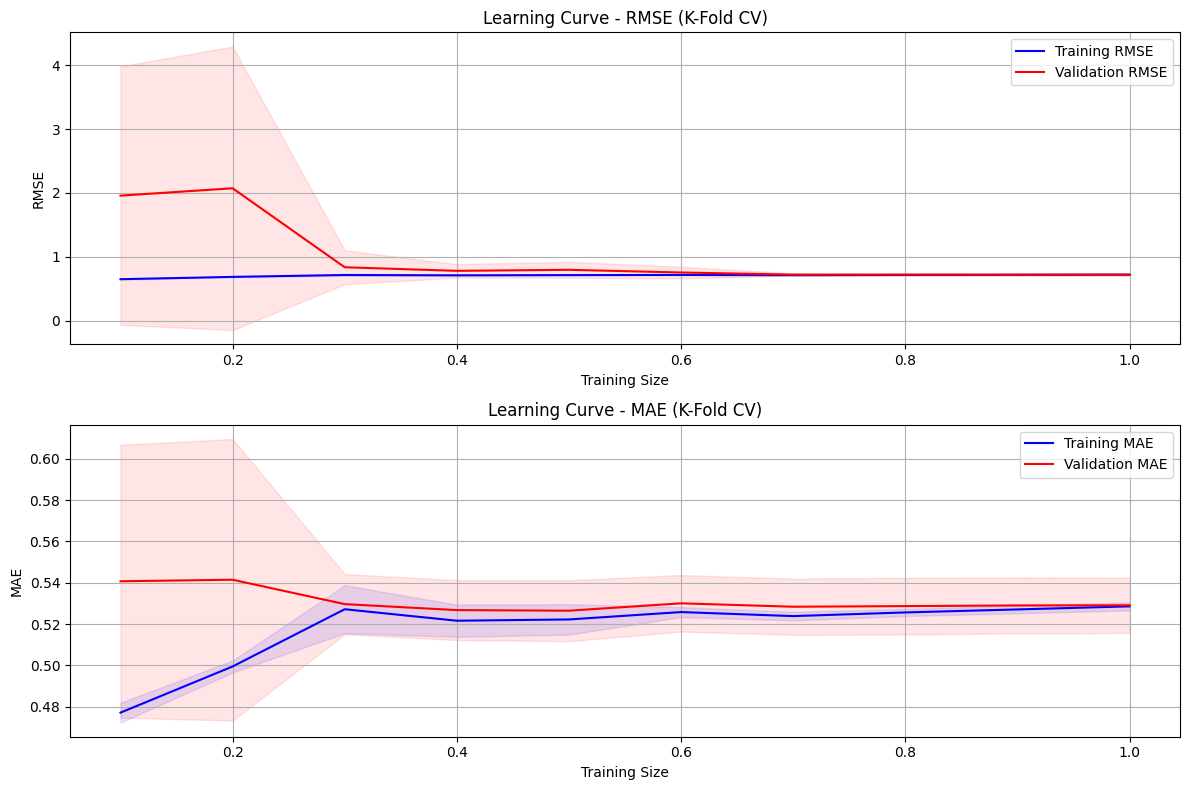

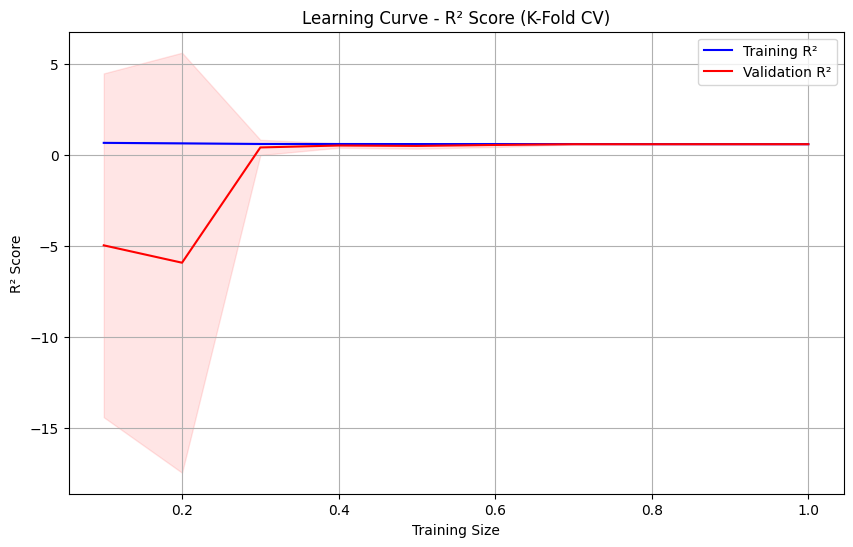

Test Set Evaluation:
Mean Squared Error (MSE): 0.5559
Root Mean Squared Error (RMSE): 0.7456
Mean Absolute Error (MAE): 0.5332
R² Score: 0.5758


In [ ]:
data = fetch_california_housing()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes_rmse, train_scores_rmse, test_scores_rmse = learning_curve(
    model, X_train, y_train, cv=KFold(n_splits=8, shuffle=True, random_state=42),
    train_sizes=train_sizes, scoring='neg_root_mean_squared_error', n_jobs=-1
)

train_sizes_mae, train_scores_mae, test_scores_mae = learning_curve(
    model, X_train, y_train, cv=KFold(n_splits=8, shuffle=True, random_state=42),
    train_sizes=train_sizes, scoring='neg_mean_absolute_error', n_jobs=-1
)

train_sizes_r2, train_scores_r2, test_scores_r2 = learning_curve(
    model, X_train, y_train, cv=KFold(n_splits=8, shuffle=True, random_state=42),
    train_sizes=train_sizes, scoring='r2', n_jobs=-1
)

train_mean_rmse = -np.mean(train_scores_rmse, axis=1)
test_mean_rmse = -np.mean(test_scores_rmse, axis=1)
train_std_rmse = np.std(train_scores_rmse, axis=1)
test_std_rmse = np.std(test_scores_rmse, axis=1)

train_mean_mae = -np.mean(train_scores_mae, axis=1)
test_mean_mae = -np.mean(test_scores_mae, axis=1)
train_std_mae = np.std(train_scores_mae, axis=1)
test_std_mae = np.std(test_scores_mae, axis=1)

train_mean_r2 = np.mean(train_scores_r2, axis=1)
test_mean_r2 = np.mean(test_scores_r2, axis=1)
train_std_r2 = np.std(train_scores_r2, axis=1)
test_std_r2 = np.std(test_scores_r2, axis=1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(train_sizes, train_mean_rmse, label="Training RMSE", color='blue')
plt.plot(train_sizes, test_mean_rmse, label="Validation RMSE", color='red')
plt.fill_between(train_sizes, train_mean_rmse - train_std_rmse, train_mean_rmse + train_std_rmse, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean_rmse - test_std_rmse, test_mean_rmse + test_std_rmse, alpha=0.1, color='red')
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("Learning Curve - RMSE (K-Fold CV)")
plt.legend(loc="best")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(train_sizes, train_mean_mae, label="Training MAE", color='blue')
plt.plot(train_sizes, test_mean_mae, label="Validation MAE", color='red')
plt.fill_between(train_sizes, train_mean_mae - train_std_mae, train_mean_mae + train_std_mae, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean_mae - test_std_mae, test_mean_mae + test_std_mae, alpha=0.1, color='red')
plt.xlabel("Training Size")
plt.ylabel("MAE")
plt.title("Learning Curve - MAE (K-Fold CV)")
plt.legend(loc="best")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean_r2, label="Training R²", color='blue')
plt.plot(train_sizes, test_mean_r2, label="Validation R²", color='red')
plt.fill_between(train_sizes, train_mean_r2 - train_std_r2, train_mean_r2 + train_std_r2, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean_r2 - test_std_r2, test_mean_r2 + test_std_r2, alpha=0.1, color='red')
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.title("Learning Curve - R² Score (K-Fold CV)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R² Score: {r2_test:.4f}")


## Sources  

1. [Neuromatch - Model Fitting](https://compneuro.neuromatch.io/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial6.html)  
2. [DataCamp - K-Fold Cross-Validation](https://www.datacamp.com/tutorial/k-fold-cross-validation)  
3. [Scikit-Learn - KFold Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)  
4. [Scikit-Learn - Cross-Validation Guide](https://scikit-learn.org/stable/modules/cross_validation.html)  
5. [Neptune.ai - Cross-Validation in Machine Learning](https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right)  
6. [GitHub - Resampling and K-Fold Code](https://github.com/rasbt/model-eval-article-supplementary/blob/master/code/resampling-and-kfold.ipynb)
7. [kaggle - Comparison of model validation methods](https://www.kaggle.com/code/therval/comparison-of-model-validation-methods)  
8. Book : An introduction to Stastical Learning
  - Ch-5 : Resampling Methods
9. Book : Artificial Intelligence : A modern approach
  - Ch - 18.4 : Evaluating and choosing the best hypothesis.
10. Book : Understanding Machine Learning From Theory to Algorithms
  - Ch - 11 : Model Selection and Validation
